| Status                             | Meaning                         | What it means in your data                                                                         |
| ---------------------------------- | ------------------------------- | -------------------------------------------------------------------------------------------------- |
| **200 OK**                         | Request succeeded               | The page or API endpoint was returned correctly.                                                   |
| **304 Not Modified**               | Cached version is still valid   | The client already had the resource and the server said “no change”. Common for static files.      |
| **302 Found (Temporary Redirect)** | Redirect to another URL         | The server redirected the user (e.g., login, HTTPS redirect, or URL change).                       |
| **404 Not Found**                  | Resource does not exist         | Broken links, missing pages, bad URLs, or crawlers probing random paths.                           |
| **403 Forbidden**                  | Access denied                   | The client is blocked or lacks permission (IP blocked, auth required).                             |
| **500 Internal Server Error**      | Server crashed while processing | Bug, memory error, timeout, or bad backend logic.                                                  |
| **501 Not Implemented**            | Method not supported            | The server doesn’t recognize the request method (e.g., PUT on a server that only allows GET/POST). |
| **400 Bad Request**                | Malformed request               | Invalid syntax, missing parameters, or corrupted requests.                                         |


After Normalized: 

200 -> Success

304 -> No Change

302 -> Redirected

404 -> Not Found

Others -> Error

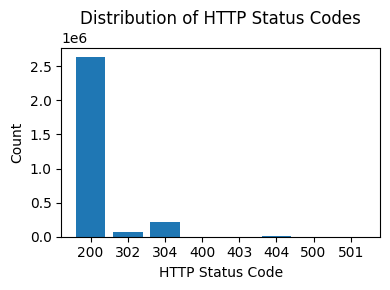

In [52]:
status_counts = df["status"].value_counts().sort_index()

plt.figure(figsize=(4, 3))
plt.bar(status_counts.index.astype(str), status_counts.values)

plt.xlabel("HTTP Status Code")
plt.ylabel("Count")
plt.title("Distribution of HTTP Status Codes")
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd 
import numpy as np
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA 
# from PyEMD.EMD import EMD
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# if project_root not in sys.path:
#     sys.path.append(project_root)

# from shared_functions.gg_sheet_drive import *

In [30]:
def read_csv(name = 'train', interval = '1min'): # for some random reasons I have to create a read_csv function, nice  ¯\_(ツ)_/¯

    df = pd.read_csv(f"/kaggle/input/datasetssss/{name}.csv")

    df['time'] = pd.to_datetime(df['time'])
    df['status'] = df['status'].astype(int)
    df['size'] = df['size'].astype(float)

    # Time resampling for forecasting
    df_agg = (
        df
        .set_index("time")
        .groupby("status_label")
        .resample(interval, level=0)["size"]
        .sum()
        .reset_index()
        .fillna(0)
    )

    return df, df_agg

train, train_time = read_csv('train')
test, test_time = read_csv('test')

In [31]:
train_time.shape

(379945, 3)

In [11]:
train_time

,status_label,time,size
0,Error,1995-07-02 00:55:00,0.000000
1,Error,1995-07-02 01:00:00,0.000000
2,Error,1995-07-02 01:05:00,0.000000
3,Error,1995-07-02 01:10:00,0.000000
4,Error,1995-07-02 01:15:00,0.000000
...,...,...,...
75985,Success,1995-08-22 23:35:00,22528.000000
75986,Success,1995-08-22 23:40:00,30486.333333
75987,Success,1995-08-22 23:45:00,13049.637097
75988,Success,1995-08-22 23:50:00,9068.705426


In [12]:
train_time = train_time[train_time['status_label'] == 'Success']
test_time = test_time[test_time['status_label'] == 'Success']

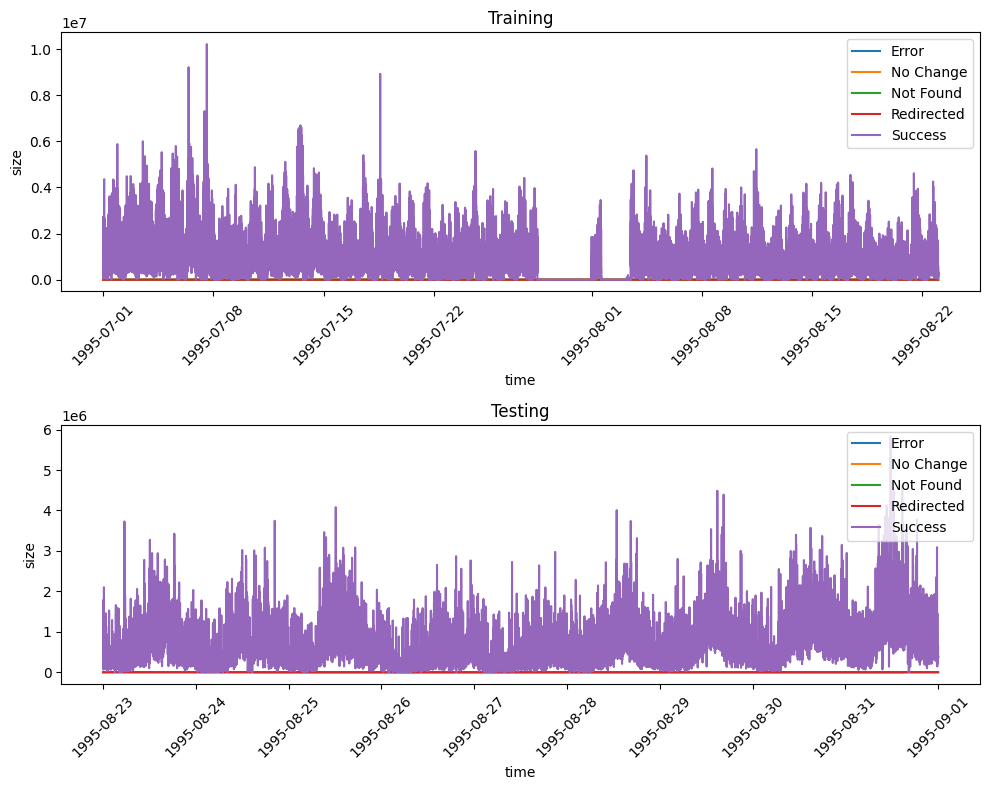

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.lineplot(data=train_time, x="time", y="size",
             hue="status_label", ax=axes[0])
axes[0].set_title("Training")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(loc="upper right")

sns.lineplot(data=test_time, x="time", y="size",
             hue="status_label", ax=axes[1])
axes[1].set_title("Testing")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Looks predictable?

#### Extract some necessary features for reporting (maybe no use in forecasting)


In [ ]:
# hits/sec

hits_per_sec = df.set_index("time").resample("1S").size()

C:\Users\admin\AppData\Local\Temp\ipykernel_1624\1729525887.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  hits_per_sec = df.set_index("time").resample("1S").size()


In [ ]:
# error rate (also per sec)

df["is_error"] = df["status"] >= 400 # if Not Found is also counted as Error

error_rate = (
    df.set_index("time")
      .resample("1s")
      .apply(lambda x: x["is_error"].mean())
)

In [ ]:
#spikes

window = 60  # 1 minute window

rolling_mean = hits_per_sec.rolling(window).mean()
rolling_std = hits_per_sec.rolling(window).std()

zscore = (hits_per_sec - rolling_mean) / rolling_std

spikes = zscore > 3

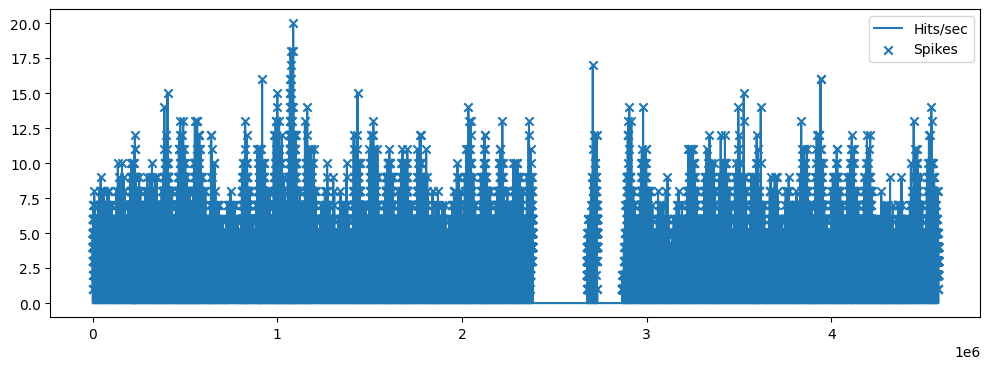

In [29]:
metrics = pd.DataFrame({
    "hits_per_sec": hits_per_sec,
    "error_rate": error_rate,
    "is_spike": spikes
})

metrics = metrics.fillna(0)
metrics = metrics.reset_index()

plt.figure(figsize=(12,4))
plt.plot(metrics.index, metrics["hits_per_sec"], label="Hits/sec")
plt.scatter(metrics[metrics.is_spike].index,
            metrics[metrics.is_spike]["hits_per_sec"],
            marker="x", label="Spikes")
plt.legend()
plt.show()

#### Forecasting

In [ ]:
train_time.head(1)

,status_label,time,size
0,Error,1995-07-02 00:55:00,0.000000
1,Error,1995-07-02 00:56:00,0.000000
2,Error,1995-07-02 00:57:00,0.000000
3,Error,1995-07-02 00:58:00,0.000000
4,Error,1995-07-02 00:59:00,0.000000
...,...,...,...
379940,Success,1995-08-22 23:55:00,24594.307692
379941,Success,1995-08-22 23:56:00,20766.714286
379942,Success,1995-08-22 23:57:00,13396.400000
379943,Success,1995-08-22 23:58:00,17693.625000


In [ ]:
test_time.head(1)

#### Some ARIMA, SARIMAX might help 

In [25]:
result = adfuller(train_time['size'])

print(f"The ADFuller yields the test statistic {result[0]} and the p-value {result[1]}, which means the series is {'non-' if result[1] > 0.05 else ''}stationary")

The ADFuller yields the test statistic -4.226282246698696 and the p-value 0.0005945586881635197, which means the series is stationary


In [13]:
def acf_pacf(series):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))
    plot_acf(series, ax=axes[0], lags=30, title='ACF')
    plot_pacf(series, ax=axes[1], lags=30, title='PACF')
    axes[0].set_ylim(-0.5, 0.5)
    axes[1].set_ylim(-0.5, 0.5)
    plt.tight_layout()

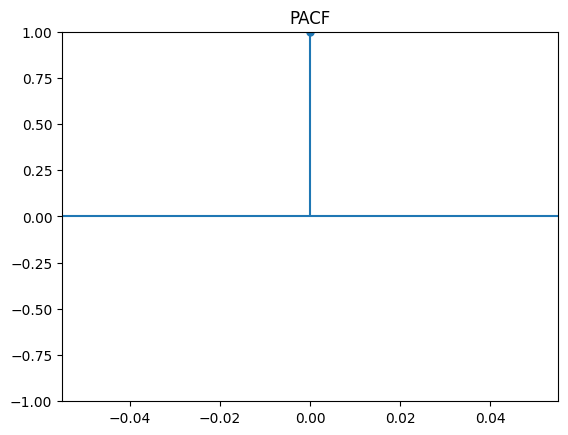

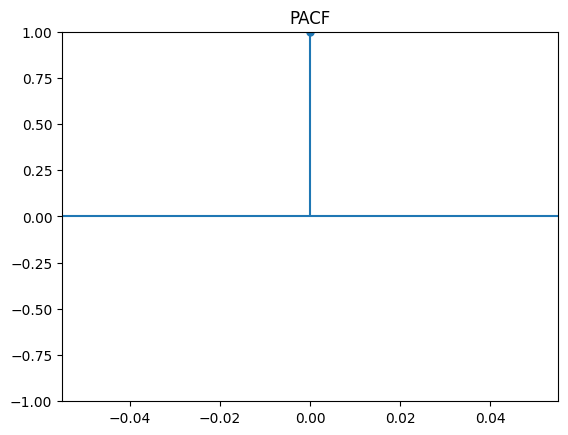

In [26]:
plot_pacf(train['size'], lags=30, title='PACF')

In [28]:
def plot_prediction(train:pd.DataFrame = train, test:pd.DataFrame = test, col:str = 'size', pred:str = None):
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=train[date_col], y=train[col], label='Train')
    sns.lineplot(x=test[date_col], y=test[col], label='Test')
    sns.lineplot(x=test[date_col], y=pred, label='Prediction')
    plt.tight_layout()
    
    y_true = test[col].values
    y_pred = np.asarray(pred)

    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) 
    r2 = r2_score(y_true, y_pred)
    
    print(f'RMSE: {rmse}, MAPE: {mape}, R2: {r2}')

In [29]:
def arima(p,d,q, col): 
    arima = ARIMA(train[col], order=(p, d, q)).fit()

    pred = arima.forecast(steps = len(test))

    plot_prediction(train = train, test = test, col = col, pred = pred)

In [ ]:
arima(1,0,1, col = 'size')

In [14]:
def for_dl_input_lstm(series, window_size=10):
    series = np.asarray(series, dtype=np.float32)
    
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    
    X = np.array(X).reshape(-1, window_size, 1)  # Shape: (samples, window_size, 1) - 3D for LSTM
    y = np.array(y)
    
    return X, y

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden=128, mlp_hidden1=64, mlp_hidden2=32,
        output_size=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden,
        batch_first=True, num_layers=2, dropout=dropout)
        self.mlp = nn.Sequential(
        nn.Linear(lstm_hidden, mlp_hidden1),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden1, mlp_hidden2),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden2, output_size)
        )
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x) # output shape: (batch, seq_len, lstm_hidden)
        last_out = lstm_out[:, -1, :] # take last time step
        return self.mlp(last_out)


In [33]:
X_train, y_train = for_dl_input_lstm(train_time['size'], window_size = 60)
X_test, y_test = for_dl_input_lstm(test_time['size'], window_size = 60)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [34]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_train_tensor, y_train_tensor)

loader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True
)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [ ]:
model = LSTM(input_size=X_train.shape[-1], output_size=1, dropout=0.5).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(50):
    model.train()
    total_loss = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/50", leave=False)

    for Xb, yb in pbar:
        Xb = Xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # update progress bar text
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

Epoch 1, Avg Loss: 171735731613.6049


Epoch 2, Avg Loss: 148524465905.3270


Epoch 3, Avg Loss: 128931270899.0533


Epoch 4, Avg Loss: 110621490643.4633


Epoch 5, Avg Loss: 111371504553.6885


Epoch 6, Avg Loss: 118594052952.2104


Epoch 7, Avg Loss: 106345378486.6352


Epoch 8, Avg Loss: 105532766129.2839


Epoch 9, Avg Loss: 105745744788.9737


Epoch 10, Avg Loss: 109154438425.0303


Epoch 11, Avg Loss: 106783856347.2313


Epoch 12, Avg Loss: 105621273550.9751


Epoch 13, Avg Loss: 107127857744.4424


Epoch 14, Avg Loss: 106829800856.0809


Epoch 15, Avg Loss: 106429211697.0249


Epoch 16, Avg Loss: 105840680201.8395


Epoch 17, Avg Loss: 106106633861.6102


Epoch 18, Avg Loss: 106458577828.1645


Epoch 19, Avg Loss: 106616010506.1848


Epoch 20, Avg Loss: 106126246742.8294


Epoch 21, Avg Loss: 106801755388.0297


Epoch 22, Avg Loss: 110229572101.8692


Epoch 23, Avg Loss: 106964507190.2036


Epoch 24, Avg Loss: 106859422612.9737


Epoch 25, Avg Loss: 106857463585.6615


Epoch 26, Avg Loss: 106140635091.8085


Epoch 27, Avg Loss: 106095160895.1800


Epoch 28, Avg Loss: 105948704671.3311


Epoch 29, Avg Loss: 106133486385.5428


Epoch 30, Avg Loss: 203024056825.4403


Epoch 31, Avg Loss: 165114432320.7336


Epoch 32, Avg Loss: 109651272624.5934


Epoch 33, Avg Loss: 111342869193.9690


Epoch 34, Avg Loss: 108022773108.1753


Epoch 35, Avg Loss: 106738367987.2259


Epoch 36, Avg Loss: 106094761580.7525


Epoch 37, Avg Loss: 107052369257.1274


Epoch 38/50:  46%|████▌     | 678/1483 [00:09<00:11, 71.14it/s, loss=106395238400.0000]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Epoch 40, Avg Loss: 106500560639.1369


Epoch 41, Avg Loss: 106774201394.4059


Epoch 42/50:   7%|▋         | 110/1483 [00:01<00:18, 72.63it/s, loss=84224057344.0000] 

In [36]:

from sklearn.metrics import r2_score, mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_pred_tensor = model(X_test_tensor).cpu()

y_pred = y_pred_tensor.numpy().ravel()
y_true = y_test.ravel()

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f"R^2: {r2:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 37.65 GiB. GPU 0 has a total capacity of 14.74 GiB of which 12.40 GiB is free. Process 2941 has 2.34 GiB memory in use. Of the allocated memory 2.05 GiB is allocated by PyTorch, and 157.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<Axes: >

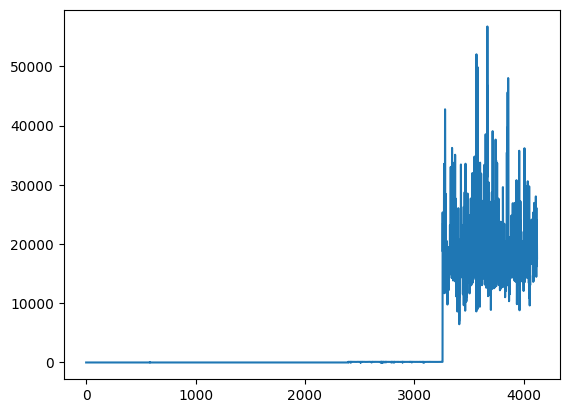

In [48]:
sns.lineplot(y_test)

In [37]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_pred = model(X_test_tensor).cpu().numpy().ravel()

y_true = y_test.ravel()

# If you have timestamps
# time_test = test_df["time"].values
# Otherwise use index
t = range(len(y_true))

plt.figure(figsize=(12, 4))
plt.plot(t, y_true, label="Real", alpha=0.7)
plt.plot(t, y_pred, label="Predicted", alpha=0.7)

plt.title("Prediction vs Real (Time Series)")
plt.xlabel("Time index")
plt.ylabel("Value")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 37.65 GiB. GPU 0 has a total capacity of 14.74 GiB of which 12.34 GiB is free. Process 2941 has 2.40 GiB memory in use. Of the allocated memory 2.18 GiB is allocated by PyTorch, and 84.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

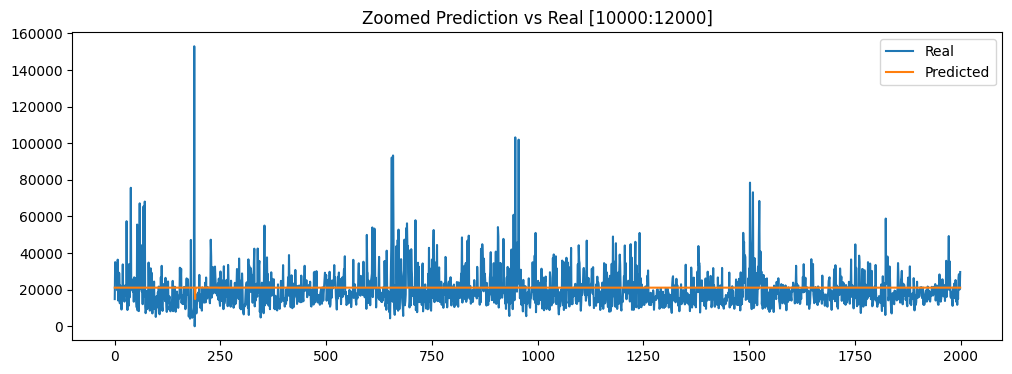

In [28]:
start = 10000
end = 12000

plt.figure(figsize=(12, 4))
plt.plot(y_true[start:end], label="Real")
plt.plot(y_pred[start:end], label="Predicted")
plt.title(f"Zoomed Prediction vs Real [{start}:{end}]")
plt.legend()
plt.show()
